CST 383: Introduction to Data Science

Project 1 - Montgomery County Crash Data

Ethan Herndon

Frank Piva


# Introduction

According to the National Highway Traffic Safety Administraion, the latest data on vehicle miles traveled shows that motorcyclists are about 28 times as likely as passenger car occupants to die in a motor vehicle traffic crash. Safe motorcycling takes balance, coordination, and good judgment.<sup>1</sup> Our goal in this project is to explore information in the data set in relation to motorcycles and see if we can confirm these statistics.

1. https://www.nhtsa.gov/road-safety/motorcycle-safety  

# About the Data

This dataset provides information on motor vehicle operators (drivers) involved in traffic collisions occurring on county and local roadways. The dataset reports details of all traffic collisions occurring on county and local roadways within Montgomery County, as collected via the Automated Crash Reporting System (ACRS) of the Maryland State Police, and reported by the Montgomery County Police, Gaithersburg Police, Rockville Police, or the Maryland-National Capital Park Police. This dataset shows each collision data recorded and the drivers involved.<sup>2</sup>

2. https://data.montgomerycountymd.gov/Public-Safety/Crash-Reporting-Drivers-Data/mmzv-x632 

# Initial Data Exploration:

To begin our analysis we start with the basics, the pandas.DataFrame.info and pandas.DataFrame.describe methods. From here we can see the names of columns, type of each column, and number of rows. We can also get some statistics about the non-object columns. We'll run the numeric columns through Seaborn's pairplot method to see if any interesting correlations can be found.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100148 entries, 0 to 100147
Data columns (total 43 columns):
Report Number                     100148 non-null object
Local Case Number                 100148 non-null object
Agency Name                       100148 non-null object
ACRS Report Type                  100148 non-null object
Crash Date/Time                   100148 non-null object
Route Type                        90559 non-null object
Road Name                         91015 non-null object
Cross-Street Type                 90549 non-null object
Cross-Street Name                 91011 non-null object
Off-Road Description              9132 non-null object
Municipality                      10943 non-null object
Related Non-Motorist              3028 non-null object
Collision Type                    99813 non-null object
Weather                           92279 non-null object
Surface Condition                 88280 non-null object
Light                             99309 non-nu

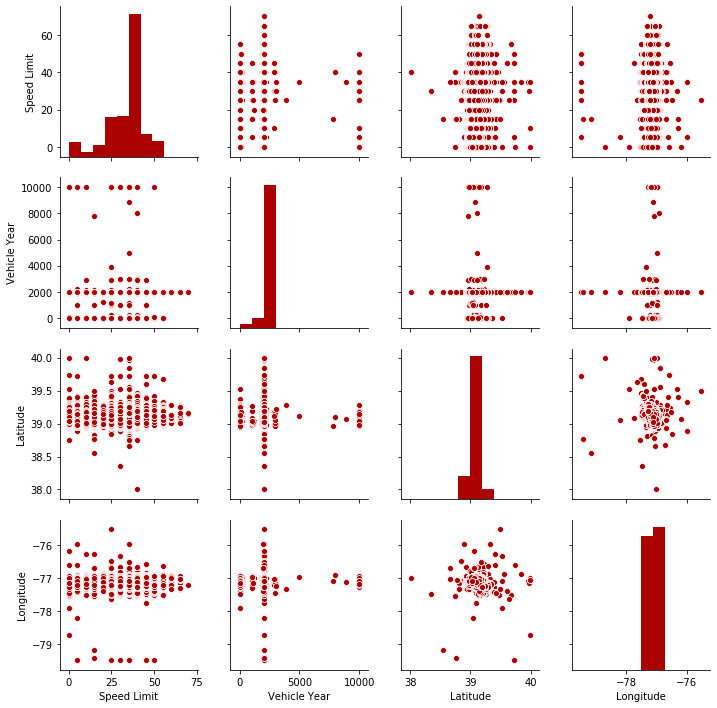

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

filepath = "./"
filename = "Crash_Reporting_-_Drivers_Data.csv"
df = pd.read_csv(filepath + filename)
print(df.info())
print(df.describe())
sns.pairplot(df)

The Lattitude vs Longitude plots are slightly interesting. It appears there is no correlation, but most of the accidents are centered in the same area. We continued to explore other areas to get a feel for the data. All plots are with respect to motorcycle accidents only.

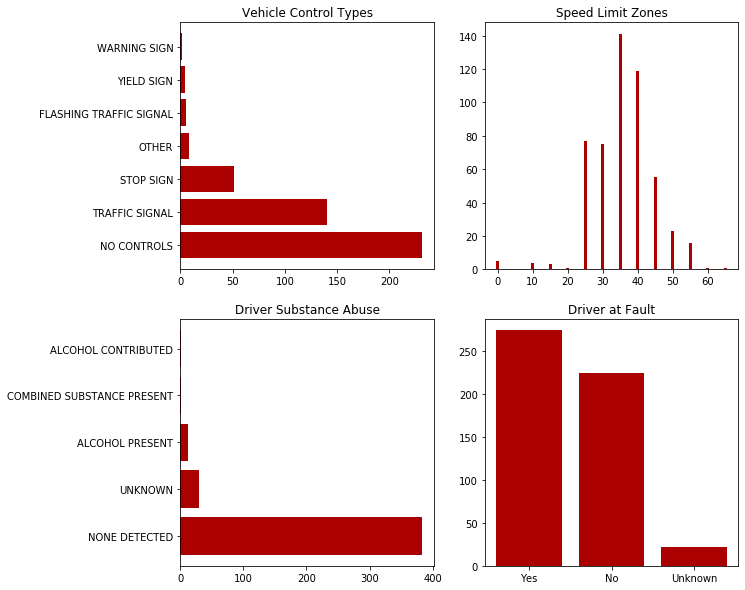

In [18]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
temp = df[df["Vehicle Body Type"] == "MOTORCYCLE"]["Traffic Control"].value_counts()
plt.barh(temp.index, temp.values)
plt.title("Vehicle Control Types");

plt.subplot(2,2,2)
temp = df[df["Vehicle Body Type"] == "MOTORCYCLE"]["Speed Limit"].value_counts()
plt.bar(temp.index, temp.values)
plt.title("Speed Limit Zones");

plt.subplot(2,2,3)
temp = df[df["Vehicle Body Type"] == "MOTORCYCLE"]["Driver Substance Abuse"].value_counts()
plt.barh(temp.index, temp.values)
plt.title("Driver Substance Abuse");

plt.subplot(2,2,4)
temp = df[df["Vehicle Body Type"] == "MOTORCYCLE"]["Driver At Fault"].value_counts()
plt.bar(temp.index, temp.values)
plt.title("Driver at Fault");

The Driver Substance Abuse plot is probably the most intersting; almost all motorcycle accidents had no detected substance abuse. Another interesting initial observation is that most accidents occured in a 35 MPH zone.

# Data Cleaning and Preprocessing

We found two major issues while exploring the data. The first issue was that the dates weren't recorded in a format that is easily understood by matplotlib. The solution to this problem was easily achieved using the pandas.to_datetime function. The second issue was more complex. For many vehicle makes there existed multiple variations on the spelling and what we assume to be misspellings, e.g. "HARDLEY DAVIDSON", "HARLEY DAVIDSON", "HARLEY-DAVIDSON", etc. The solution to this problem required more work, as we had to discover and replace all the variants for each brand we wanted to work with. Instead of cleaning the data set for all motorcycle brands, we only processed the top five.

In [19]:
df["Crash Date/Time"] = pd.to_datetime(df["Crash Date/Time"])

harley_variants = ["HARDLEY DAVIDSON", "HD", "HARL", "HARL D", "HARLE DAVIDSON",
                   "HARLEY", "HARLEY D", "HARLEY DAV", "HARLEY DAVIDSON",
                   "HARLEY DAVISON", "HARLEYDAVIDSON"]
df.replace(inplace=True, to_replace=harley_variants, value ="HARLEY-DAVIDSON")

honda_variants = ["HOND"]
df.replace(inplace=True, to_replace=honda_variants, value="HONDA")

kawasaki_variants = ["KAWA", "KAWASKI", "KAWKISKI"]
df.replace(inplace=True, to_replace=kawasaki_variants, value="KAWASAKI") 

suzuki_variants = ["SUSUKI", "SUZI", "SUZIKI", "SUZU", "SUZUKI FIVE STAR"]
df.replace(inplace=True, to_replace=suzuki_variants, value="SUZUKI") 

yamaha_variants = ["YAHAMA", "YAMA"]
df.replace(inplace=True, to_replace=yamaha_variants,value="YAMAHA")

# Data Exploration and Visualization
## Do motorcycles sustain more damage in accidents than other vehicles?

In our quest to quantify the dangers of motorcyles we wanted to look at how much more damage motorcycles sustained in an accident compared to other vehicles. For a simple comparison we split the entire data set into two categories, moto and not_moto. We then counted the different unique values for each group. We decided to drop the "OTHER" value for the non_moto group, as it only represented fifteen accidents and we are unsure of what it means.

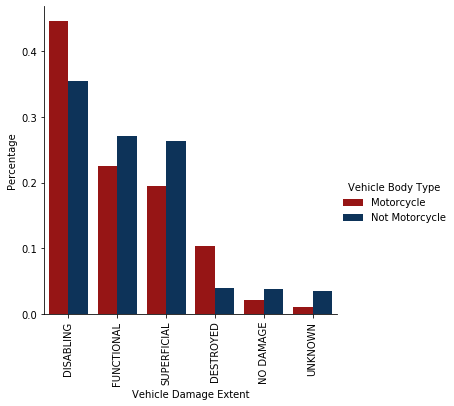

In [20]:
moto = df[df["Vehicle Body Type"] == "MOTORCYCLE"]["Vehicle Damage Extent"]
moto = moto.value_counts()
moto = moto / moto.sum()
motos = np.full(moto.size, "Motorcycle")

not_moto = df[df["Vehicle Body Type"] != "MOTORCYCLE"]["Vehicle Damage Extent"]
not_moto = not_moto.value_counts()
not_moto = not_moto.drop("OTHER") # discuss in the report
not_moto = not_moto / not_moto.sum()
not_motos = np.full(not_moto.size, "Not Motorcycle")

df1 = pd.DataFrame({
    "Vehicle Damage Extent": np.concatenate([moto.index, not_moto.index]),
    "Percentage": np.concatenate([moto.values, not_moto.values]),
    "Vehicle Body Type": np.concatenate([motos, not_motos])
})

graph1 = sns.catplot(
    data=df1,
    hue="Vehicle Body Type",
    kind="bar",
    palette=sns.set_palette(["#AB0000", "#003366"]),
    x="Vehicle Damage Extent",
    y="Percentage"
)

plt.xticks(rotation="vertical");

In this plot we see some expected information. In the "NO DAMAGE", "SUPERFICIAL", and "FUNCTIONAL" categories other vehicles all had higher percentages than motocycles; in the "DISABLING" and "DESTROYED" categories motorcycles prevailed. Although motorcyles did sustain more damage than other vehicles, it doesn't appear to be by a factor of 28. This led us to our next question.

## Do motorcycle accidents have higher rates of injury severity than other accidents?

Now that we know how much damage the vehicle sustained, we wanted to examine the rates of injury severity sustained by the operator. Similar to the last plot we split the entire data set into two categories moto and not_moto, and counted the unique values for Injury Severity when the Vehicle Damage Extent was "DISABLING". We chose this value because it offered the most data points to work with for both sets of vehicles.

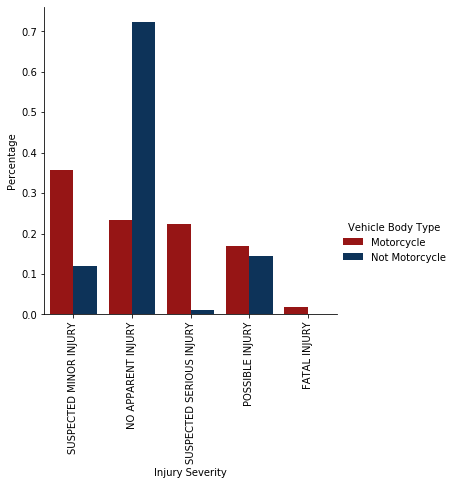

In [21]:
moto = df[
    (df["Vehicle Body Type"] == "MOTORCYCLE") &
    (df["Vehicle Damage Extent"] == "DISABLING")
]["Injury Severity"]
moto = moto.value_counts()
moto = moto / moto.sum()
motos = np.full(moto.size, "Motorcycle")

not_moto = df[
    (df["Vehicle Body Type"] != "MOTORCYCLE") &
    (df["Vehicle Damage Extent"] == "DISABLING")
]["Injury Severity"]
not_moto = not_moto.value_counts()
not_moto = not_moto / not_moto.sum()
not_motos = np.full(not_moto.size, "Not Motorcycle")

df2 = pd.DataFrame({
    "Injury Severity": np.concatenate([moto.index, not_moto.index]),
    "Percentage": np.concatenate([moto.values, not_moto.values]),
    "Vehicle Body Type": np.concatenate([motos, not_motos])
})

graph2 = sns.catplot(
    data=df2,
    hue="Vehicle Body Type",
    kind="bar",
    palette=sns.set_palette(["#AB0000", "#003366"]),
    x="Injury Severity",
    y="Percentage"
)

plt.xticks(rotation="vertical");

From this graph, we can see some significant features. About 72% of non-motorcycle operators sustain "NO APPARENT INJURY" and more than half of motorcycle operators sustain some form of injury. Another intersting point to note is that "FATAL INJURY" is virtually non-existent for non-motorcyle operators while 1.7% of motorcycle operators sustain a fatal injury in an accident.

## Are there correlations between crash year and vehicle year?

We wanted to investigate if there was any correlation between crash year and vehicle year. Unsure of what we would find we thought it would be an interesting way to visualize every motorcycle accident in the data set. While working on this plot we discovered that some vehicles had "0" listed as their Vehicle Year. We decided to drop these values to avoid skewing our plot to the left.

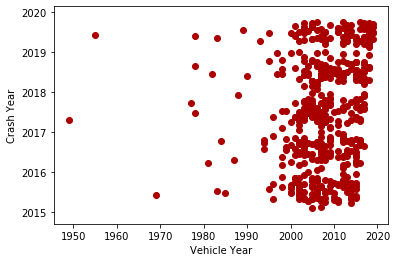

In [25]:
temp = df[df["Vehicle Body Type"] == "MOTORCYCLE"]
temp = temp.drop(temp[temp["Vehicle Year"] == 0].index)
pd.plotting.register_matplotlib_converters() # datetime converter for matplotlib plotting method
plt.scatter(temp["Vehicle Year"], temp["Crash Date/Time"])
plt.xlabel("Vehicle Year")
plt.ylabel("Crash Year");

In the above graph we can see that even after dropping the zero values there are a handful of old motorcycles that are still skewing our plot to the left. We decided to refine the plot further by only analyzing motorcycles manufactured after 1990. One piece of interesting information we do see from this graph is that less crashes occur around the year ticks on the y axis. One can infer this represents winter time in Maryland when less individuals would be operating a motorcyle. We consider this to be a good sign about the integrity of the data.

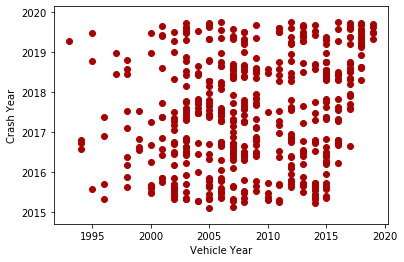

In [23]:
temp = df[df["Vehicle Body Type"] == "MOTORCYCLE"]
temp = temp.drop(temp[temp["Vehicle Year"] == 0].index) # talk about this in report
temp = temp.drop(temp[temp["Vehicle Year"] <= 1990].index) # talk about this in report
plt.scatter(temp["Vehicle Year"], temp["Crash Date/Time"])
plt.xlabel("Vehicle Year")
plt.ylabel("Crash Year");

After zooming in on the last 25 years we can see some more unexpected anomaly detection. For modern motorcyles (2015 and beyond) we can see them appear on the y axis as they are released on the x axis. If we saw a 2019 motorcyle involved in a 2017 accident we would be concerned about the integrity of the data. 

## Are some motorcyle brands more dangerous than others?

In our effort to better understand the data, we wanted to see if certain brands were more prone to accidents. Perhaps certain brands are favored by aggressive operators or maybe a manufacturer introduced a line of motorcyles that were more prone to accidents. In order to answer this question we again looked at the top five motorcyle brands in the data set. Once more we used the "DISABLING" value for the Vehicle Damage Extent category since it had the most data points for a single category.

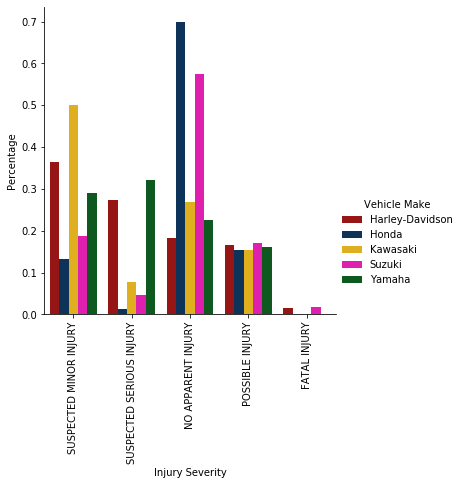

In [24]:
harley = df[
    (df["Vehicle Make"] == "HARLEY-DAVIDSON") &
    (df["Vehicle Damage Extent"] == "DISABLING")
]["Injury Severity"]
harley = harley.value_counts()
harley = harley / harley.sum()
harleys = np.full(harley.size, "Harley-Davidson")

honda = df[
    (df["Vehicle Make"] == "HONDA") &
    (df["Vehicle Damage Extent"] == "DISABLING")
]["Injury Severity"]
honda = honda.value_counts()
honda = honda / honda.sum()
hondas = np.full(honda.size, "Honda")

kawasaki = df[
    (df["Vehicle Make"] == "KAWASAKI") &
    (df["Vehicle Damage Extent"] == "DISABLING")
]["Injury Severity"]
kawasaki = kawasaki.value_counts()
kawasaki = kawasaki / kawasaki.sum()
kawasakis = np.full(kawasaki.size, "Kawasaki")

suzuki = df[
    (df["Vehicle Make"] =="SUZUKI") &
    (df["Vehicle Damage Extent"] == "DISABLING")
]["Injury Severity"]
suzuki = suzuki.value_counts()
suzuki = suzuki / suzuki.sum()
suzukis = np.full(suzuki.size, "Suzuki")

yamaha = df[
    (df["Vehicle Make"] == "YAMAHA") &
    (df["Vehicle Damage Extent"] == "DISABLING")
]["Injury Severity"]
yamaha = yamaha.value_counts()
yamaha = yamaha / yamaha.sum()
yamahas = np.full(yamaha.size, "Yamaha")

df3 = pd.DataFrame({
    "Injury Severity": np.concatenate([harley.index, honda.index, kawasaki.index, suzuki.index, yamaha.index]),
    "Percentage": np.concatenate([harley.values, honda.values, kawasaki.values, suzuki.values, yamaha.values]),
    "Vehicle Make": np.concatenate([harleys, hondas, kawasakis, suzukis, yamahas])
})

graph3 = sns.catplot(
    data=df3,
    hue="Vehicle Make",
    kind="bar",
    palette=sns.set_palette(["#AB0000", "#003366","#FFBF00", "#FF00BF","#00661A"]),
    x="Injury Severity",
    y="Percentage",
)
plt.xticks(rotation="vertical");

The above plot seems to indicate that Honda tends to be safer than other brands. It has the lowest rates of "SUSPECTED MINOR INJURY" and "SUSPECTED MAJOR INJURY", the highest rate of "NO APPARENT INJURY", and no occurences of "FATAL INJURY". By same logic Suzuki is a close second, although it does seem to have the highest occurences of "FATAL INJURY".

# Conclusion

Our biggest challenge when researching this data set was the lack of numeric data. Almost all the data was categorical and it made it hard to get meaningful distrubtions and plots. Another challenge we faced was that some of our initial ideas about potential correlations didn't exist. For example, investigating if substance abuse or high speed was factor in motorcycle collisions. Overall, the data seemed to align with the claims made by the NHTSA, the outcome of operating a motorcycle is dangerous. The likelyhood of you having an injury while operating a motorcycle is significantly higher than operating a non motorcycle.